### Name: Carl Victor A. Villaceran
<h2>Assignment 3</h2>


Instructions:
-

1. Read the article: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
2. Replicate the study using the same dataset.
3. Read articles about Adjusted Rand Index, Normalized Mutual Information, and Folkes-Mallows Index (only use paper published in IEEE, sciencedirect, springerlink, Taylor Francis).
4. Aside from the Adjusted Rand Index (ARI), and Normalized Mutual Information (NMI), use the Folkes-Mallows Index (FMI), and compare the result of each performance index.
5. Compare and contrast each performance index, what are the advantages and disadvantages of ARI, NMI, and FMI, and when to use each?
6. Using Kmodes and Hierarchical Clustering, use the same dataset and perform categorical data clustering, use FMI, ARI, and NMI for the comparison of performance.
7. Write your report using Latex. Your report should be focused on the "why's and the what's" of each performance metrices (i.e. why is FMI always greater than ARI and NMI? What's the problem with ARI and NMI?).

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
# data (as pandas dataframes) 
X = soybean_large.data.features 
y = soybean_large.data.targets 

# print head of dataset
print(X.head())
print(X.shape)

   date  plant-stand  precip  temp  hail  crop-hist  area-damaged  severity  \
0   6.0          0.0     2.0   1.0   0.0        1.0           1.0       1.0   
1   4.0          0.0     2.0   1.0   0.0        2.0           0.0       2.0   
2   3.0          0.0     2.0   1.0   0.0        1.0           0.0       2.0   
3   3.0          0.0     2.0   1.0   0.0        1.0           0.0       2.0   
4   6.0          0.0     2.0   1.0   0.0        2.0           0.0       1.0   

   seed-tmt  germination  ...  int-discolor  sclerotia  fruit-pods  \
0       0.0          0.0  ...           0.0        0.0         0.0   
1       1.0          1.0  ...           0.0        0.0         0.0   
2       1.0          2.0  ...           0.0        0.0         0.0   
3       0.0          1.0  ...           0.0        0.0         0.0   
4       0.0          2.0  ...           0.0        0.0         0.0   

   fruit-spots  seed  mold-growth  seed-discolor  seed-size  shriveling  roots  
0          4.0   0.0   

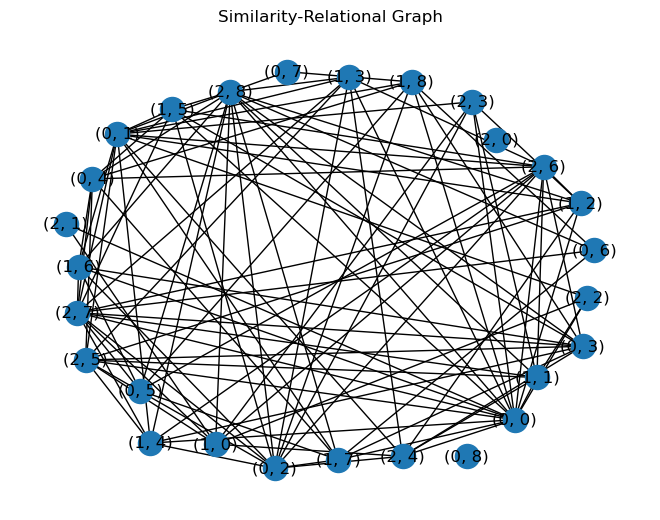

E:\Conda\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:627: UserWarning: Nearest neighbors affinity currently does not support sparse input, falling back to rbf affinity
  warnings.warn(


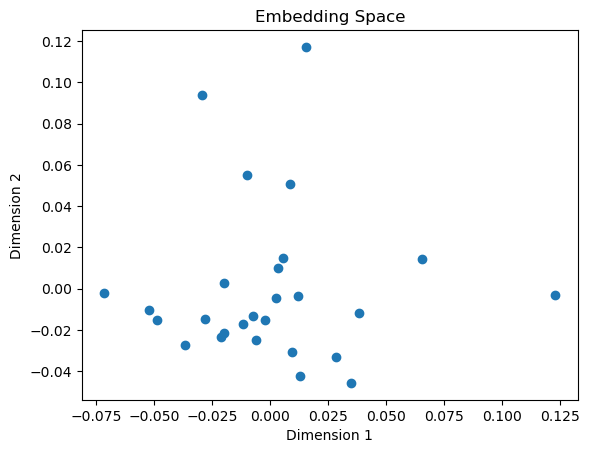

Embedding Matrix:
 [[-0.03636858 -0.0273437 ]
 [-0.02903429  0.09395092]
 [ 0.02865056 -0.03332676]
 [ 0.00253041 -0.00434265]
 [-0.00583674 -0.02484199]
 [ 0.03513502 -0.04567151]
 [ 0.00955547 -0.03068036]
 [ 0.0158421   0.11720419]
 [ 0.00861859  0.05052468]
 [-0.0712823  -0.00231988]
 [-0.0195251   0.00291209]
 [-0.00968699  0.05533288]
 [ 0.00369146  0.01010115]
 [-0.01143563 -0.01701146]
 [-0.01989084 -0.02162032]
 [-0.00736524 -0.01301737]
 [-0.00212505 -0.01495559]
 [ 0.12317211 -0.00296592]
 [ 0.06548707  0.01434654]
 [-0.05201291 -0.01024082]
 [ 0.01215195 -0.00342764]
 [-0.02809389 -0.01481457]
 [-0.02117879 -0.02322056]
 [ 0.00592108  0.01497568]
 [ 0.03858235 -0.01163343]
 [ 0.01326429 -0.04255111]
 [-0.04876612 -0.0153625 ]]


In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt

def construct_similarity_graph(X):

    G = nx.Graph()
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X).toarray()
    
    similarity_matrix = cosine_similarity(X_encoded)
    
    n_samples, n_features = X_encoded.shape
    for i in range(n_samples):
        for j in range(n_features):
            G.add_node((i, j))
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            for k in range(n_features):
                for l in range(k+1, n_features):
                    sim = similarity_matrix[i, j]
                    G.add_edge((i, k), (j, l), weight=sim)
    
    return G

def graph_embedding(X, embedding_dim=2):

    G = construct_similarity_graph(X)
    nx.draw(G, with_labels=True)
    plt.title('Similarity-Relational Graph')
    plt.show()
    spectral_embedding = SpectralEmbedding(n_components=embedding_dim)
    embedding_matrix = spectral_embedding.fit_transform(nx.adjacency_matrix(G))

    plt.scatter(embedding_matrix[:, 0], embedding_matrix[:, 1])
    plt.title('Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    
    return embedding_matrix

# Perform graph embedding
embedding_matrix = graph_embedding(X)
print("Embedding Matrix:\n", embedding_matrix)

In [8]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
import pandas as pd
from sklearn.impute import SimpleImputer

# Data 
X = soybean_large.data.features 
y = soybean_large.data.targets 

# One-hot encode categorical features
X_encoded = pd.get_dummies(X)

# Function to perform clustering and calculate performance indices
def evaluate_clustering(X, y_true, method='kmeans'):
    if method == 'kmeans':
        clustering = KMeans(n_clusters=len(np.unique(y_true))).fit(X)
    elif method == 'hierarchical':
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(y_true))).fit(X)
    else:
        raise ValueError("Invalid clustering method. Use 'kmeans' or 'hierarchical'.")
    
    y_pred = clustering.labels_
    ari = adjusted_rand_score(y_true.values.ravel(), y_pred)
    nmi = normalized_mutual_info_score(y_true.values.ravel(), y_pred)
    fmi = fowlkes_mallows_score(y_true.values.ravel(), y_pred)

    
    return ari, nmi, fmi

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X_encoded)

# Perform clustering and evaluate with different methods
ari_kmeans, nmi_kmeans, fmi_kmeans = evaluate_clustering(X_imputed, y, method='kmeans')
ari_hierarchical, nmi_hierarchical, fmi_hierarchical = evaluate_clustering(X_imputed, y, method='hierarchical')

# Print the results
print("KMeans:")
print("Adjusted Rand Index (ARI):", ari_kmeans)
print("Normalized Mutual Information (NMI):", nmi_kmeans)
print("Folkes-Mallows Index (FMI):", fmi_kmeans)

print("\nHierarchical Clustering:")
print("Adjusted Rand Index (ARI):", ari_hierarchical)
print("Normalized Mutual Information (NMI):", nmi_hierarchical)
print("Folkes-Mallows Index (FMI):", fmi_hierarchical)

E:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans:
Adjusted Rand Index (ARI): 0.40171612346851454
Normalized Mutual Information (NMI): 0.6716909200751828
Folkes-Mallows Index (FMI): 0.4492543268970205

Hierarchical Clustering:
Adjusted Rand Index (ARI): 0.4818572638479213
Normalized Mutual Information (NMI): 0.7714741801659014
Folkes-Mallows Index (FMI): 0.5238794514629941


$\textbf{Introduction to the Report}$
<br>
A fundamental aspect of unsupervised learning is clustering, which involves grouping data points together based on their similarities or shared attributes. To assess the efficacy of clustering algorithms in forming meaningful groups, it is crucial to evaluate their performance. This evaluation is facilitated by various metrics, each offering its unique strengths and limitations. This report will delve into three widely recognized metrics used to evaluate clustering performance: the Folkes-Mallows Index (FMI), the Normalized Mutual Information (NMI), and the Adjusted Rand Index (ARI), discussing the rationale, benefits, drawbacks, and typical use cases for each.

$\textbf{Adjusted Rand Index (ARI)}$:
The Adjusted Rand Index (ARI) quantifies the agreement between two different clustering outcomes by considering all sample pairs and their cluster assignments. It incorporates an adjustment for chance to establish a baseline for random clustering, which involves comparing the expected similarity in randomly assigned clusters with the actual observed clustering. This adjustment makes ARI a robust measure that factors in all sample pairs and their cluster memberships.

$\textbf{Advantage}$:
- ARI quantitatively gauges the concordance between two clusterings, with its values ranging from -1 to 1, where 1 denotes perfect agreement.
- It is particularly useful when validated ground truth labels are available, making it a popular choice in scenarios where the actual cluster assignments are known.

$\textbf{Disadvantage}$:
- ARI may not account for the actual labels directly, making it sensitive to the number of clusters and their distribution.
- Its values are not bounded to positive numbers and may be difficult to interpret due to potential negative values.

$\textbf{Normalized Mutual Information (NMI)}$:
Normalized Mutual Information (NMI) assesses the mutual dependency between the actual labels and the predicted clusters, with adjustments for chance influences. It offers a normalized measure of agreement that ranges from 0 to 1, where 1 signifies perfect concordance. NMI evaluates the shared information between the true and predicted labels, normalizing the results to prevent the scale of information from affecting the measure.

$\textbf{Advantage}$:
- NMI provides a normalized and symmetric measure, which simplifies interpretation and ensures that it does not vary with the order of true and predicted labels.
- The symmetry of NMI makes it less biased toward the arrangement of data, promoting a more equitable evaluation of clustering performance.

$\textbf{Disadvantage}$:
- NMI might show a preference for clusters of uniform size, potentially overlooking the clustering’s tendency to either over-segment or under-segment.

$\textbf{Folkes-Mallows Index (FMI)}$:
The Folkes-Mallows Index (FMI) evaluates the clustering by calculating the geometric mean of precision and recall with respect to the true classifications. This index provides a balanced metric that considers both the presence of false positives and false negatives, offering a dual perspective on the accuracy of the clustering.

$\textbf{Advantage}$:
- FMI is adept at providing a balanced assessment of precision and recall, making it suitable for a thorough evaluation of clustering outcomes.
- By considering both false positives and false negatives, FMI offers a comprehensive view of the clustering’s performance, providing detailed insights into its effectiveness.

$\textbf{Disadvantage}$:
- Despite its utility, FMI may not be as frequently utilized or as familiar as ARI or NMI, which can result in less recognition and usage in practice.

$\textbf{Conclusion of the Report}$
<br>
In conclusion, each metric for assessing the performance of clustering algorithms brings distinct advantages and inherent limitations. ARI is valuable when precise ground truth labels are accessible, although its sensitivity to cluster quantity and size can affect its performance. NMI offers a normalized agreement measure between actual labels and clustering results, albeit potentially favoring evenly sized clusters. Conversely, FMI provides a fair and balanced evaluation of both precision and recall, shedding light on both false positives and false negatives. Understanding the characteristics of each metric is vital for selecting the most appropriate one based on the specific requirements of the clustering task.


